In [130]:
import os
import random
import collections
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [132]:
def getEmails( folder ):
    '''
        Given a folder to retrieve from, 
        returns a
    '''
    emails = []
    file_list = os.listdir( folder )
    for a_file in file_list:
        with open(folder + '/' + a_file, 'r') as f:
            emails.append( f.read() )
     
    return [ [ w for w in email.split() if w.isalpha() ] for email in emails ]

def probabilities( emails ):
    '''
        Given a list of the words in emails of the same label
        Returns a dictionary that map words to probabilties
    '''
    rm_dups = lambda l : list(set( l ))
    counter = collections.Counter( sum(map(rm_dups, emails), [] ) )
    return { k : v / len( emails ) for k, v in counter.items() }

def getMostProbable( dist, n ):
    '''
        Given a probability distribution and a number of instances to get,
        returns the n most probable instances
    '''
    items = list( dist.items() )
    items.sort( key = lambda x : -x[1] )
    return dict( items[ : n ] )

In [135]:
emails = [['asdf', 'qwer'], ['asdf', 'zxcv', 'zxcv']]
reduce( lambda x, y : set(), emails)

In [136]:
spam = probabilities( getEmails( 'spam') )
ham  = probabilities( getEmails( 'ham' ) )

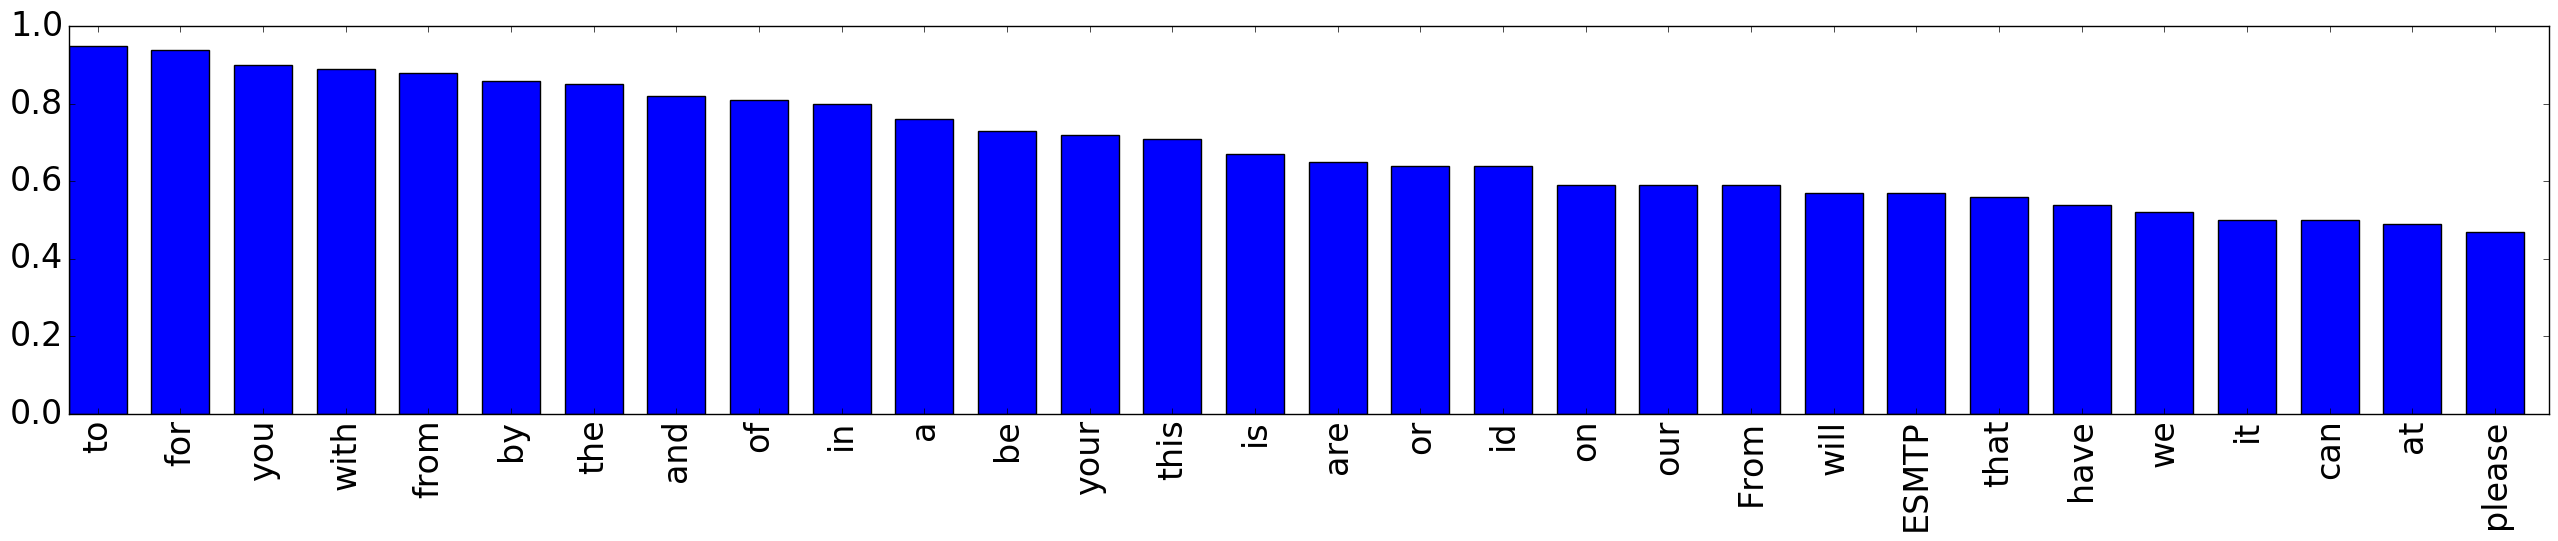

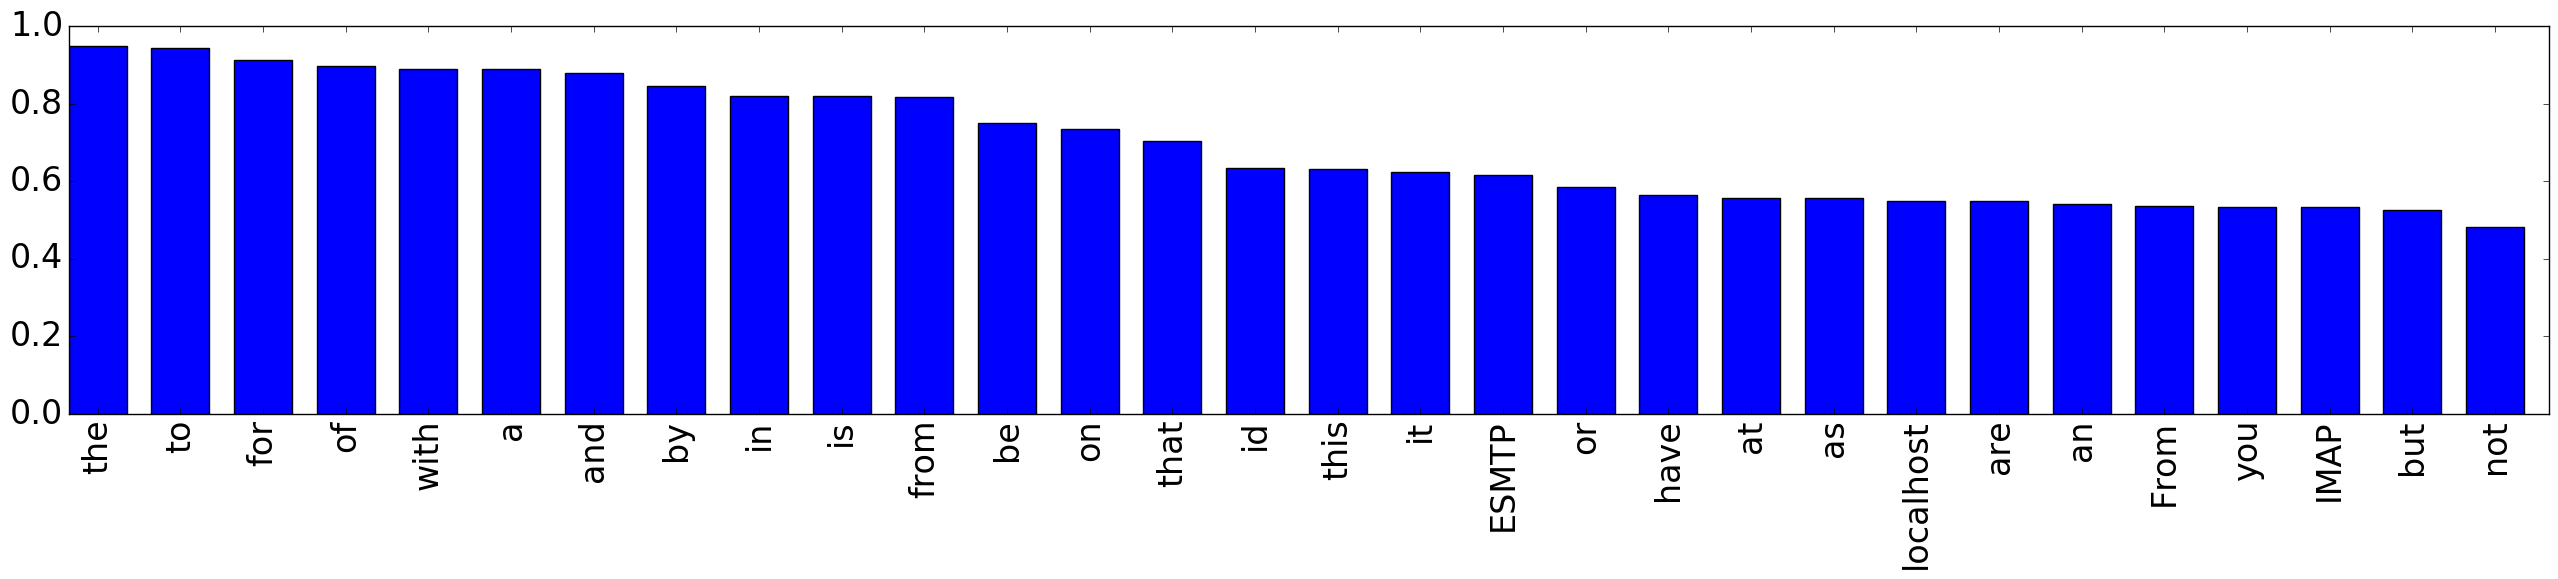

In [137]:
def plotHist( dist ):
    items = list( dist.items() )
    items.sort( key = lambda x : -x[1] )
    author_names = [ k for k, v in items ]
    author_counts = [ v for k, v in items ]

    # Plot histogram using matplotlib bar().
    indexes = np.arange(len(author_names))
    width = 0.7
    pylab.rcParams['figure.figsize'] = (32.0, 5.0)
    plt.bar( indexes, author_counts, width)
    plt.xticks(indexes + width * 0.5, author_names, rotation = 90)
    plt.show()
    
plotHist( getMostProbable( spam, 30 ) )
plotHist( getMostProbable( ham, 30 ) )

Top 30 words that positively identify spam


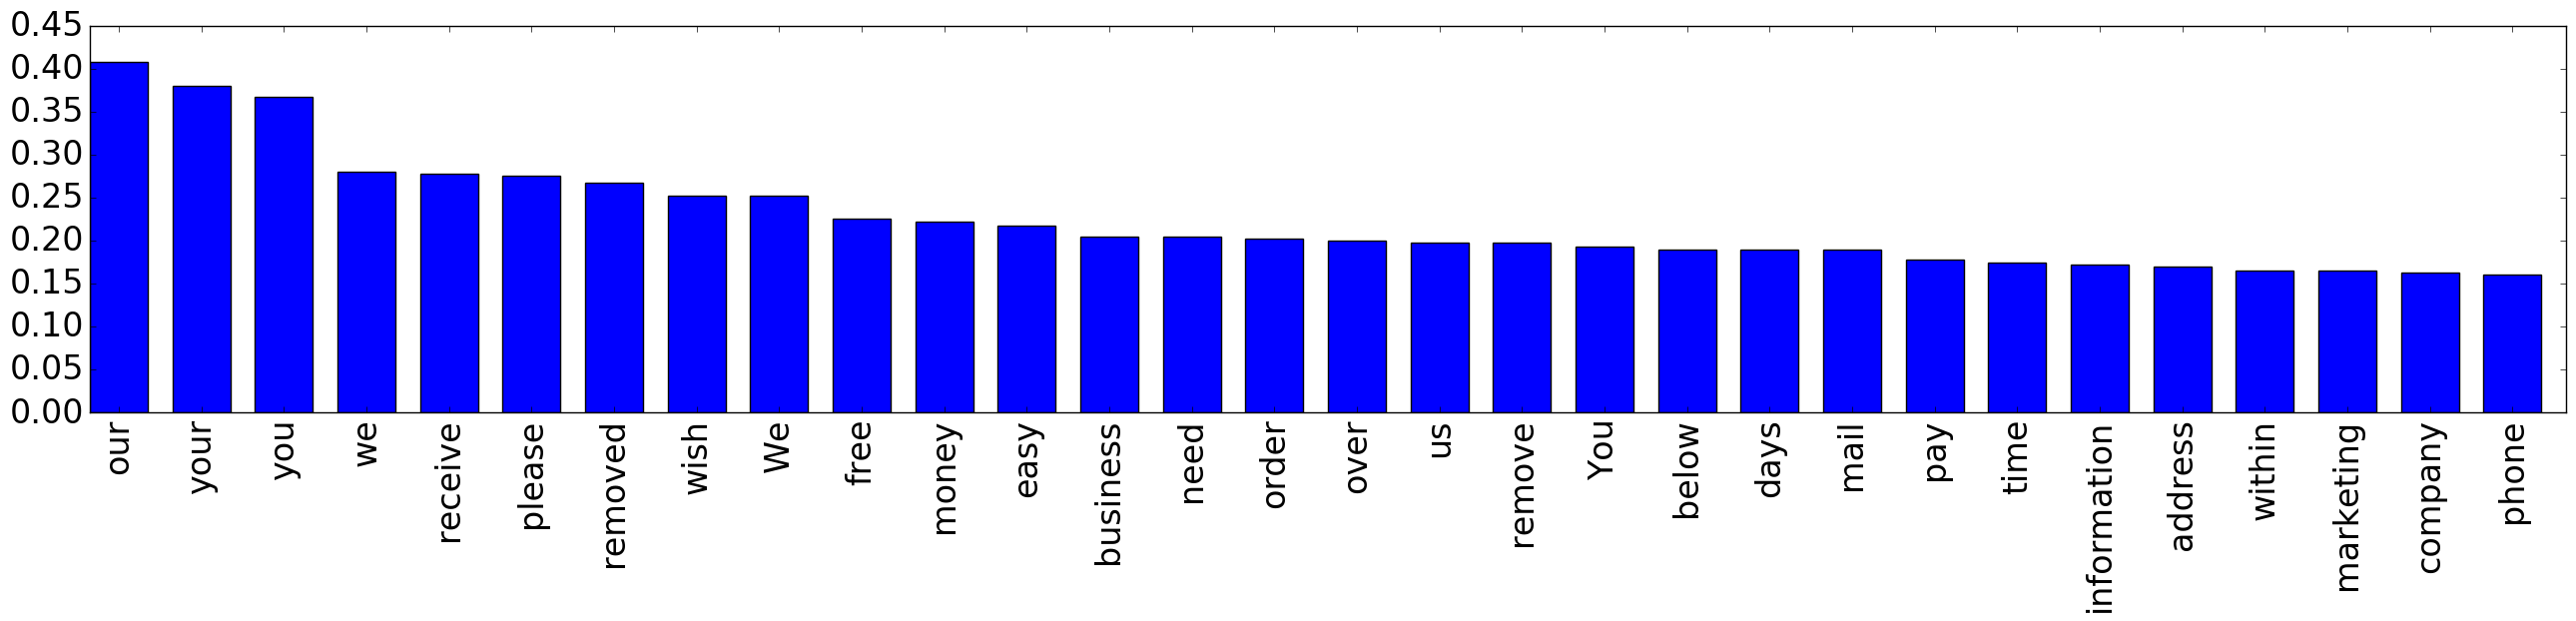

Top 30 words that positively identify ham


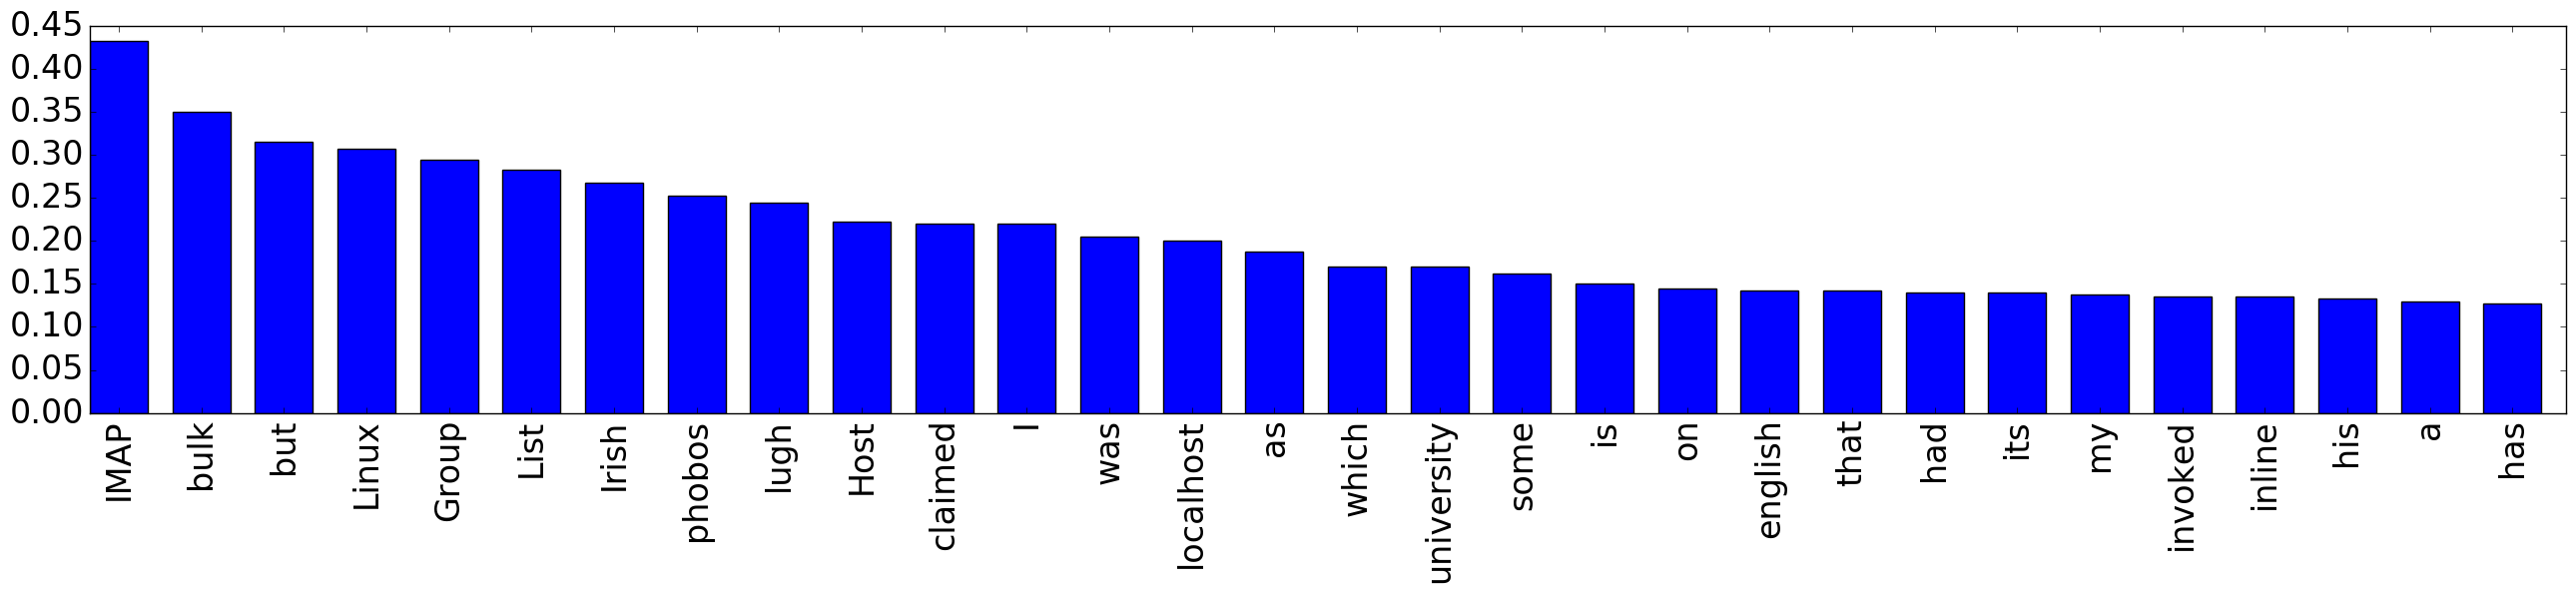

In [128]:
def histDifference( hist1, hist2 ):
    diff = {}
    for k in hist1.keys():
        if k in hist2:
            diff[ k ] = hist1[ k ] - hist2[ k ]
    return diff

diff = histDifference( spam, ham )
print( 'Top 30 words that positively identify spam' )
plotHist( getMostProbable( diff, 30 ) )

diff = histDifference( ham, spam )
print( 'Top 30 words that positively identify ham' )
plotHist( getMostProbable( diff, 30 ) )